In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


In [3]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [4]:
trainpd = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')
testpd = pd.read_csv('/kaggle/input/digit-recognizer/test.csv')

In [5]:
print(trainpd.shape)
print(testpd.shape)

(42000, 785)
(28000, 784)


In [6]:
train_images = torch.Tensor(trainpd.drop(columns='label').to_numpy()).reshape(-1,1,28,28)
train_labels = torch.LongTensor(trainpd['label'])
test_images = torch.Tensor(testpd.to_numpy()).reshape(-1,1,28,28)

In [7]:
print(train_images.shape)
print(train_labels.shape)
print(test_images.shape)

torch.Size([42000, 1, 28, 28])
torch.Size([42000])
torch.Size([28000, 1, 28, 28])


label: 1


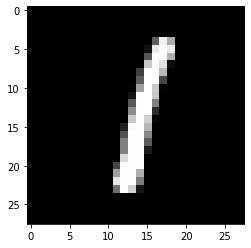

In [10]:
plt.imshow(train_images[2589].squeeze(), cmap='gray')
print('label:',train_labels[2589].item())

In [11]:
train_dataset = torch.utils.data.TensorDataset(train_images, train_labels)
# train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=100)

In [12]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5)

        self.fc1 = nn.Linear(in_features=4*4*12, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=60)
        self.out = nn.Linear(in_features=60, out_features=10)

    def forward(self, t):

        t = self.conv1(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2)

        t = self.conv2(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2)

        t = t.reshape(-1, 4*4*12)
        # t.flatten(start_dim=1)
        t = self.fc1(t)
        t = F.relu(t)

        t = self.fc2(t)
        t = F.relu(t)

        t = self.out(t)

        return t

In [13]:
def weights_init(layer):
    classname = layer.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.kaiming_normal_(layer.weight.data, nonlinearity='relu')  # He-initialization
        # ref : https://pytorch.org/docs/stable/nn.init.html#torch.nn.init.kaiming_normal_
        
# Reference : https://discuss.pytorch.org/t/weight-initilzation/157

In [14]:
network = Network()
network.apply(weights_init)
network

Network(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 12, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=192, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=60, bias=True)
  (out): Linear(in_features=60, out_features=10, bias=True)
)

In [15]:
batch_size=100
lr=0.002
iterations=50
loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
optimizer = optim.Adam(network.parameters(), lr=lr)

total_loss = []
total_correct = []

for epoch in range(iterations):

    epoch_loss = 0
    epoch_correct = 0
    for i, batch in enumerate(loader):
        batch_loss = 0
        batch_correct = 0
        
        images, labels = batch

        preds = network(images)
        loss = F.cross_entropy(preds, labels)

        optimizer.zero_grad()

        loss.backward()
        optimizer.step()

        batch_loss = loss.item()
        batch_correct = preds.argmax(dim=1).eq(labels).sum().item()
        
        epoch_loss += batch_loss
        epoch_correct += batch_correct

        total_loss.append(batch_loss)
        total_correct.append(batch_correct)
        
        if not (i+1)%21:
            print('Epoch: {}, Batch: {:>3}, Loss: {:.5f}, Accuracy: {:.2f}%'.format(epoch + 1, i+1, 
                                                                    batch_loss,
                                                                    batch_correct/len(labels)*100))


Epoch: 1, Batch:  21, Loss: 1.36714, Accuracy: 54.00%
Epoch: 1, Batch:  42, Loss: 0.62212, Accuracy: 82.00%
Epoch: 1, Batch:  63, Loss: 0.75906, Accuracy: 78.00%
Epoch: 1, Batch:  84, Loss: 0.48476, Accuracy: 84.00%
Epoch: 1, Batch: 105, Loss: 0.29947, Accuracy: 91.00%
Epoch: 1, Batch: 126, Loss: 0.30383, Accuracy: 88.00%
Epoch: 1, Batch: 147, Loss: 0.26439, Accuracy: 92.00%
Epoch: 1, Batch: 168, Loss: 0.37771, Accuracy: 88.00%
Epoch: 1, Batch: 189, Loss: 0.43090, Accuracy: 90.00%
Epoch: 1, Batch: 210, Loss: 0.34940, Accuracy: 91.00%
Epoch: 1, Batch: 231, Loss: 0.31896, Accuracy: 93.00%
Epoch: 1, Batch: 252, Loss: 0.24514, Accuracy: 93.00%
Epoch: 1, Batch: 273, Loss: 0.19043, Accuracy: 93.00%
Epoch: 1, Batch: 294, Loss: 0.17508, Accuracy: 94.00%
Epoch: 1, Batch: 315, Loss: 0.08249, Accuracy: 97.00%
Epoch: 1, Batch: 336, Loss: 0.21780, Accuracy: 91.00%
Epoch: 1, Batch: 357, Loss: 0.12413, Accuracy: 98.00%
Epoch: 1, Batch: 378, Loss: 0.11495, Accuracy: 95.00%
Epoch: 1, Batch: 399, Loss: 

Epoch: 8, Batch: 273, Loss: 0.05998, Accuracy: 98.00%
Epoch: 8, Batch: 294, Loss: 0.00760, Accuracy: 100.00%
Epoch: 8, Batch: 315, Loss: 0.06282, Accuracy: 99.00%
Epoch: 8, Batch: 336, Loss: 0.08609, Accuracy: 96.00%
Epoch: 8, Batch: 357, Loss: 0.03742, Accuracy: 99.00%
Epoch: 8, Batch: 378, Loss: 0.11750, Accuracy: 97.00%
Epoch: 8, Batch: 399, Loss: 0.06902, Accuracy: 99.00%
Epoch: 8, Batch: 420, Loss: 0.04107, Accuracy: 99.00%
Epoch: 9, Batch:  21, Loss: 0.01426, Accuracy: 99.00%
Epoch: 9, Batch:  42, Loss: 0.03691, Accuracy: 98.00%
Epoch: 9, Batch:  63, Loss: 0.12639, Accuracy: 96.00%
Epoch: 9, Batch:  84, Loss: 0.01033, Accuracy: 99.00%
Epoch: 9, Batch: 105, Loss: 0.01995, Accuracy: 99.00%
Epoch: 9, Batch: 126, Loss: 0.02819, Accuracy: 98.00%
Epoch: 9, Batch: 147, Loss: 0.00204, Accuracy: 100.00%
Epoch: 9, Batch: 168, Loss: 0.00330, Accuracy: 100.00%
Epoch: 9, Batch: 189, Loss: 0.02740, Accuracy: 98.00%
Epoch: 9, Batch: 210, Loss: 0.08715, Accuracy: 96.00%
Epoch: 9, Batch: 231, Los

Epoch: 16, Batch:  42, Loss: 0.02811, Accuracy: 99.00%
Epoch: 16, Batch:  63, Loss: 0.01785, Accuracy: 99.00%
Epoch: 16, Batch:  84, Loss: 0.02196, Accuracy: 99.00%
Epoch: 16, Batch: 105, Loss: 0.01862, Accuracy: 99.00%
Epoch: 16, Batch: 126, Loss: 0.00164, Accuracy: 100.00%
Epoch: 16, Batch: 147, Loss: 0.00209, Accuracy: 100.00%
Epoch: 16, Batch: 168, Loss: 0.02181, Accuracy: 99.00%
Epoch: 16, Batch: 189, Loss: 0.02040, Accuracy: 99.00%
Epoch: 16, Batch: 210, Loss: 0.05062, Accuracy: 98.00%
Epoch: 16, Batch: 231, Loss: 0.03713, Accuracy: 99.00%
Epoch: 16, Batch: 252, Loss: 0.01249, Accuracy: 100.00%
Epoch: 16, Batch: 273, Loss: 0.01648, Accuracy: 99.00%
Epoch: 16, Batch: 294, Loss: 0.00449, Accuracy: 100.00%
Epoch: 16, Batch: 315, Loss: 0.04447, Accuracy: 98.00%
Epoch: 16, Batch: 336, Loss: 0.00842, Accuracy: 100.00%
Epoch: 16, Batch: 357, Loss: 0.09199, Accuracy: 98.00%
Epoch: 16, Batch: 378, Loss: 0.04439, Accuracy: 98.00%
Epoch: 16, Batch: 399, Loss: 0.00155, Accuracy: 100.00%
Epoc

Epoch: 23, Batch: 210, Loss: 0.00217, Accuracy: 100.00%
Epoch: 23, Batch: 231, Loss: 0.10703, Accuracy: 99.00%
Epoch: 23, Batch: 252, Loss: 0.02323, Accuracy: 99.00%
Epoch: 23, Batch: 273, Loss: 0.04936, Accuracy: 97.00%
Epoch: 23, Batch: 294, Loss: 0.00017, Accuracy: 100.00%
Epoch: 23, Batch: 315, Loss: 0.00020, Accuracy: 100.00%
Epoch: 23, Batch: 336, Loss: 0.01480, Accuracy: 99.00%
Epoch: 23, Batch: 357, Loss: 0.00145, Accuracy: 100.00%
Epoch: 23, Batch: 378, Loss: 0.02409, Accuracy: 99.00%
Epoch: 23, Batch: 399, Loss: 0.00553, Accuracy: 100.00%
Epoch: 23, Batch: 420, Loss: 0.01144, Accuracy: 99.00%
Epoch: 24, Batch:  21, Loss: 0.06023, Accuracy: 98.00%
Epoch: 24, Batch:  42, Loss: 0.11640, Accuracy: 97.00%
Epoch: 24, Batch:  63, Loss: 0.01489, Accuracy: 100.00%
Epoch: 24, Batch:  84, Loss: 0.00059, Accuracy: 100.00%
Epoch: 24, Batch: 105, Loss: 0.00082, Accuracy: 100.00%
Epoch: 24, Batch: 126, Loss: 0.00682, Accuracy: 100.00%
Epoch: 24, Batch: 147, Loss: 0.01626, Accuracy: 99.00%
E

Epoch: 30, Batch: 378, Loss: 0.01575, Accuracy: 99.00%
Epoch: 30, Batch: 399, Loss: 0.03944, Accuracy: 99.00%
Epoch: 30, Batch: 420, Loss: 0.01357, Accuracy: 99.00%
Epoch: 31, Batch:  21, Loss: 0.02582, Accuracy: 99.00%
Epoch: 31, Batch:  42, Loss: 0.02671, Accuracy: 99.00%
Epoch: 31, Batch:  63, Loss: 0.02669, Accuracy: 99.00%
Epoch: 31, Batch:  84, Loss: 0.00047, Accuracy: 100.00%
Epoch: 31, Batch: 105, Loss: 0.01245, Accuracy: 99.00%
Epoch: 31, Batch: 126, Loss: 0.01124, Accuracy: 99.00%
Epoch: 31, Batch: 147, Loss: 0.00120, Accuracy: 100.00%
Epoch: 31, Batch: 168, Loss: 0.00021, Accuracy: 100.00%
Epoch: 31, Batch: 189, Loss: 0.02527, Accuracy: 99.00%
Epoch: 31, Batch: 210, Loss: 0.02032, Accuracy: 99.00%
Epoch: 31, Batch: 231, Loss: 0.00132, Accuracy: 100.00%
Epoch: 31, Batch: 252, Loss: 0.00327, Accuracy: 100.00%
Epoch: 31, Batch: 273, Loss: 0.00446, Accuracy: 100.00%
Epoch: 31, Batch: 294, Loss: 0.01259, Accuracy: 99.00%
Epoch: 31, Batch: 315, Loss: 0.00910, Accuracy: 99.00%
Epoc

Epoch: 38, Batch: 126, Loss: 0.00150, Accuracy: 100.00%
Epoch: 38, Batch: 147, Loss: 0.00267, Accuracy: 100.00%
Epoch: 38, Batch: 168, Loss: 0.00026, Accuracy: 100.00%
Epoch: 38, Batch: 189, Loss: 0.00841, Accuracy: 99.00%
Epoch: 38, Batch: 210, Loss: 0.04098, Accuracy: 98.00%
Epoch: 38, Batch: 231, Loss: 0.01180, Accuracy: 99.00%
Epoch: 38, Batch: 252, Loss: 0.00195, Accuracy: 100.00%
Epoch: 38, Batch: 273, Loss: 0.02239, Accuracy: 99.00%
Epoch: 38, Batch: 294, Loss: 0.00000, Accuracy: 100.00%
Epoch: 38, Batch: 315, Loss: 0.00027, Accuracy: 100.00%
Epoch: 38, Batch: 336, Loss: 0.00932, Accuracy: 99.00%
Epoch: 38, Batch: 357, Loss: 0.00096, Accuracy: 100.00%
Epoch: 38, Batch: 378, Loss: 0.02512, Accuracy: 99.00%
Epoch: 38, Batch: 399, Loss: 0.00676, Accuracy: 100.00%
Epoch: 38, Batch: 420, Loss: 0.00179, Accuracy: 100.00%
Epoch: 39, Batch:  21, Loss: 0.00215, Accuracy: 100.00%
Epoch: 39, Batch:  42, Loss: 0.04042, Accuracy: 98.00%
Epoch: 39, Batch:  63, Loss: 0.00468, Accuracy: 100.00%

Epoch: 45, Batch: 294, Loss: 0.00022, Accuracy: 100.00%
Epoch: 45, Batch: 315, Loss: 0.00013, Accuracy: 100.00%
Epoch: 45, Batch: 336, Loss: 0.02932, Accuracy: 99.00%
Epoch: 45, Batch: 357, Loss: 0.00031, Accuracy: 100.00%
Epoch: 45, Batch: 378, Loss: 0.08966, Accuracy: 99.00%
Epoch: 45, Batch: 399, Loss: 0.00240, Accuracy: 100.00%
Epoch: 45, Batch: 420, Loss: 0.00264, Accuracy: 100.00%
Epoch: 46, Batch:  21, Loss: 0.04077, Accuracy: 99.00%
Epoch: 46, Batch:  42, Loss: 0.00304, Accuracy: 100.00%
Epoch: 46, Batch:  63, Loss: 0.05703, Accuracy: 98.00%
Epoch: 46, Batch:  84, Loss: 0.00005, Accuracy: 100.00%
Epoch: 46, Batch: 105, Loss: 0.00200, Accuracy: 100.00%
Epoch: 46, Batch: 126, Loss: 0.02962, Accuracy: 99.00%
Epoch: 46, Batch: 147, Loss: 0.02356, Accuracy: 99.00%
Epoch: 46, Batch: 168, Loss: 0.00020, Accuracy: 100.00%
Epoch: 46, Batch: 189, Loss: 0.00035, Accuracy: 100.00%
Epoch: 46, Batch: 210, Loss: 0.00076, Accuracy: 100.00%
Epoch: 46, Batch: 231, Loss: 0.00085, Accuracy: 100.00

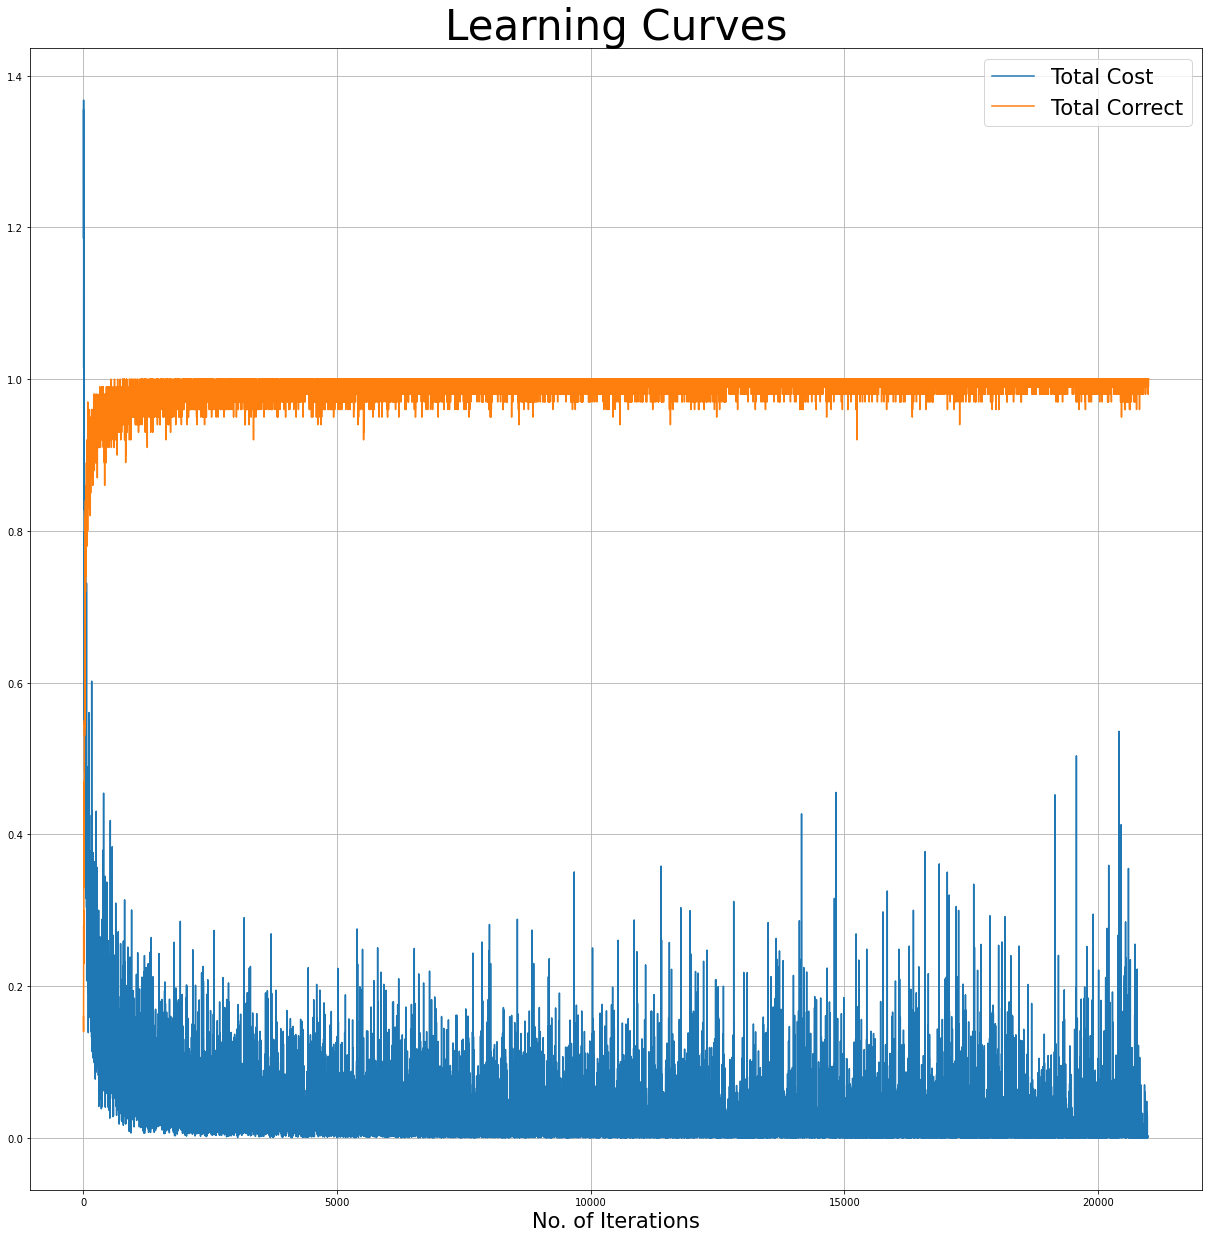

In [30]:
figure, axes = plt.subplots(figsize = (21,21))

axes.plot(total_loss[21:], label = 'Total Cost')
axes.plot([tc/100 for tc in total_correct[21:]], label = 'Total Correct')
axes.set_xlabel('No. of Iterations', fontsize=21)
axes.set_title('Learning Curves', fontsize=42)
axes.legend(fontsize=21)
axes.grid()
plt.show()

In [ ]:
total_preds = network(train_images)
total_correct = total_preds.argmax(dim=1).eq(train_labels).sum().item()
total_correct

In [ ]:
total_correct / len(train_images) *100

In [ ]:
test_preds = network(test_images)
Label = test_preds.argmax(dim = 1)

In [ ]:
testdf = pd.read_csv('/kaggle/input/digit-recognizer/sample_submission.csv')
testdf['Label'] = Label

In [ ]:
testdf.shape

In [ ]:
testdf.head()

In [ ]:
testdf.to_csv("testdf.csv", index=None)